### Making Predictions with Google Trends

This workbook tries to analyse the possibility of making predictions by using the data provided by google trends. As an example it is tried to predict the share price of the german stock index DAX.

First, let's read in the necessary libraries.

In [1]:
from pytrends.request import TrendReq
#from yahoo_finance import Share
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from time import sleep
import googletrends_prediction as gp
import seaborn as sns
%matplotlib inline

Now let's read in the necessary data from google and prepare to use it in the model.

In [2]:
kw_list = ['dax', 'etf', 'german economy', 'gold', 'oil', 'government bond', 'euro', 'MSCI World', 'eurostoxx', 'bmw', 'allianz', 'vw', 'eon', 'lufthansa', 'fresenius', 'bayer', 'adidas']
start_year = 2004

#get the data from google
input_df = gp.create_google_trend_df(kw_list, start_year)

#drop null values if no search term has a value
input_df = input_df.dropna(axis=0, how='all')

#set the null values to 0 in the other cases
input_df = input_df.fillna(0)

input_df.head()

,dax,etf,german economy,gold,oil,government bond,euro,MSCI World,eurostoxx,bmw,allianz,vw,eon,lufthansa,fresenius,bayer,adidas
date,,,,,,,,,,,,,,,,,
2004-01-01,63,23,0,77,64,0,14,0,0,78,52,92.0,16,59,46,36,54
2004-01-02,65,36,0,76,75,26,13,0,36,76,47,80.0,16,62,47,40,56
2004-01-03,45,28,0,74,78,31,13,0,0,77,22,87.0,0,70,28,27,64
2004-01-04,37,13,0,74,68,59,13,0,41,81,21,77.0,18,65,27,45,63
2004-01-05,79,40,100,93,82,0,9,0,0,56,67,61.0,27,31,0,29,42


#### Question 1

**1.** How far in the future should we look with our prediction? 

To answer this question let's adapt the response_df so that the adjusted close becomes the adjusted close of a day in the future. Let's do this for 30 days and have a look at the mean, median, maximum and minimum of the absolut values of the correlation between the google trends results and that value.

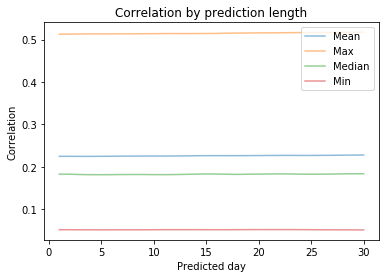

The mean has the maximum at 30.0 days.
The median has the maximum at 30.0 days.
The max has the maximum at 30.0 days.
The min has the maximum at 20.0 days.


In [4]:
d = {'days': [], 'mean': [], 'median': [], 'max': [], 'min': []}
>>> df_mean_corr = pd.DataFrame(data=d)

for i in range(1,31):
    #get the datat to predict from yahoo finance
    response_df = pd.read_csv('./input/DAX_Kursverlauf.csv')
    response_df = response_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
    response_df['Date'] =  pd.to_datetime(response_df['Date'])
    
    #substract some days from the date colums so that the Adj Close becomes the Adj Close of the future
    response_df['Date'] = response_df['Date'] - timedelta(days=i)
    new_name = 'Adj Close in ' + str(i) + ' days'
    response_df = response_df.rename(columns={'Adj Close': new_name})

    response_df = response_df.set_index('Date')

    #Put the two datasets together to bring them in the right shape
    total_df = input_df.merge(response_df, how='outer', left_index=True, right_index=True)

    #fill null values 
    #by using ffill the weekends in the yahoo finance data will be filled with the value from friday
    #the google trends results are not affected since they only might contain null values at the beginning (when the timeframes didn't match)
    total_df = total_df.fillna(method='ffill')

    #drop null values 
    #all rows from the beginning where the google trends results or the yahoo finance data is missing
    total_df = total_df.dropna(axis=0, how='all')
    
    #create the correlation dataframe
    corr_df = total_df.corr()
    corr_df = corr_df[corr_df.index != new_name]
    mean_corr = corr_df[new_name].abs().mean()
    max_corr = corr_df[new_name].abs().max()
    median_corr = corr_df[new_name].abs().median()
    min_corr = corr_df[new_name].abs().min()
    
    #add the mean to the df_mean_corr_dataframe
    df_mean_corr = df_mean_corr.append({'days': i, 'mean': mean_corr, 'median': median_corr, 'max': max_corr, 'min': min_corr}, ignore_index=True)

#Get the maximal Days with the maximal correlation
days_forecast_mean = df_mean_corr[df_mean_corr['mean'] == df_mean_corr['mean'].max()]['days'].max()
days_forecast_max = df_mean_corr[df_mean_corr['max'] == df_mean_corr['max'].max()]['days'].max()
days_forecast_median = df_mean_corr[df_mean_corr['median'] == df_mean_corr['median'].max()]['days'].max()
days_forecast_min = df_mean_corr[df_mean_corr['min'] == df_mean_corr['min'].max()]['days'].max()

#plot the result
plt.plot(df_mean_corr['days'], df_mean_corr['mean'], label="Mean", alpha=.5)
plt.plot(df_mean_corr['days'], df_mean_corr['max'], label="Max", alpha=.5)
plt.plot(df_mean_corr['days'], df_mean_corr['median'], label="Median", alpha=.5)
plt.plot(df_mean_corr['days'], df_mean_corr['min'], label="Min", alpha=.5)
plt.xlabel('Predicted day')
plt.ylabel('Correlation')
plt.title('Correlation by prediction length')
plt.legend(loc=1)
plt.show()

print('The mean has the maximum at ' + str(days_forecast_mean) + ' days.')
print('The median has the maximum at ' + str(days_forecast_median) + ' days.')
print('The max has the maximum at ' + str(days_forecast_max) + ' days.')
print('The min has the maximum at ' + str(days_forecast_min) + ' days.')            

There is no big difference in all of the values. Therefore there shouldn't be too big differences in the accuracy of the models depending on the day in the future chosen for the prediction. 

From business reasons let's therefore choose 30 days to make the prediction for. Which seems by the way also to be the day on which the maximum and the mean are maximal. 

Now we can get the dataframe we use for our model.

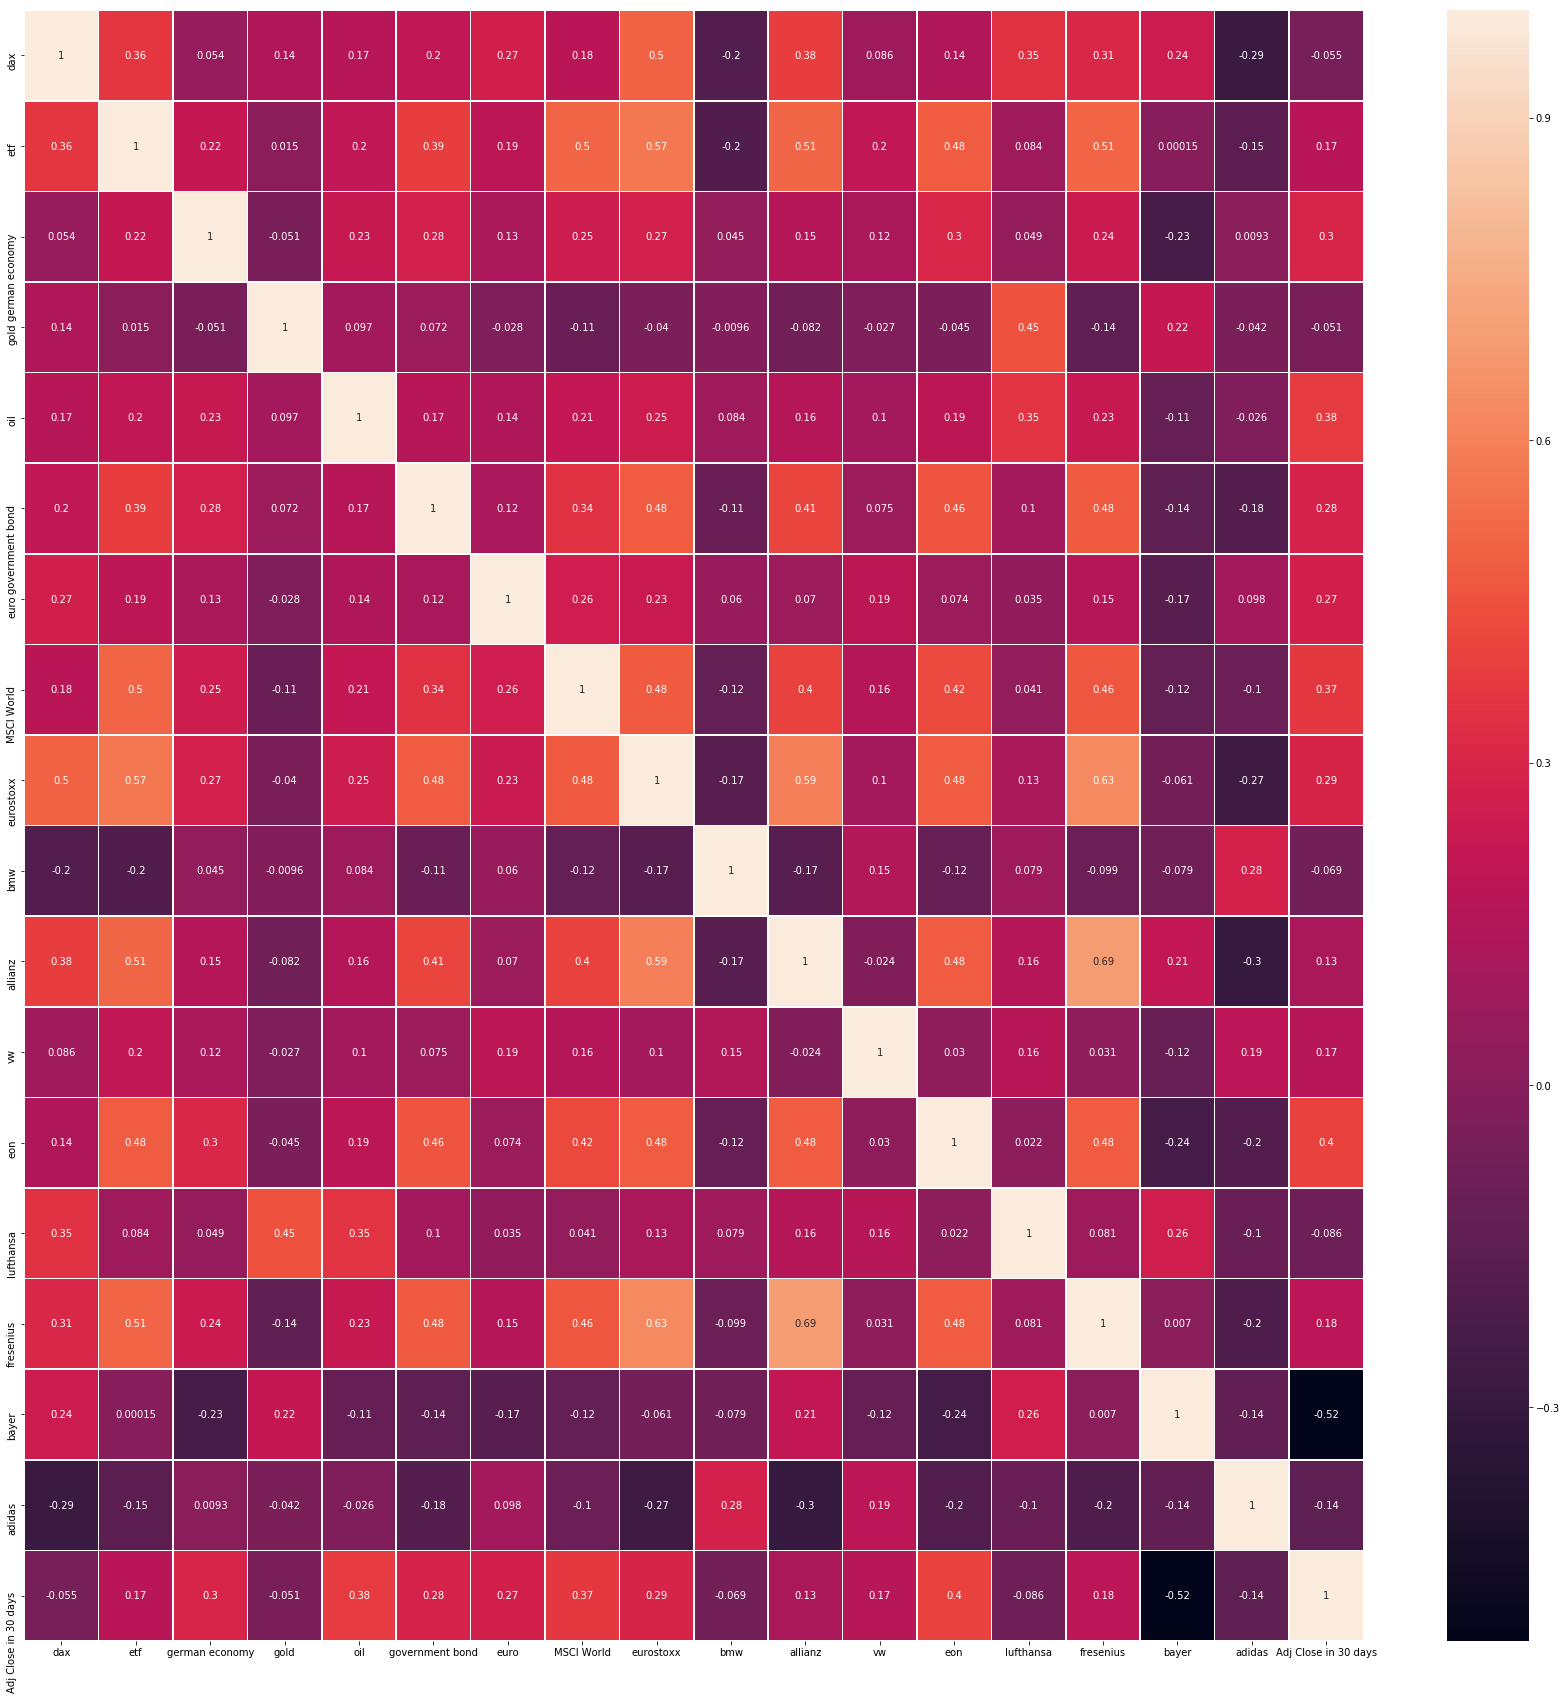

In [5]:
#Set the day in the future the prediction should be made for
days_forecast = 30

#get the datat to predict from yahoo finance
response_df = pd.read_csv('./input/DAX_Kursverlauf.csv')
response_df = response_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
response_df['Date'] =  pd.to_datetime(response_df['Date'])

#substract some days from the date colums so that the Adj Close becomes the Adj Close of the future
response_df['Date'] = response_df['Date'] - timedelta(days=days_forecast)
new_name = 'Adj Close in ' + str(days_forecast) + ' days'
response_df = response_df.rename(columns={'Adj Close': new_name})

response_df = response_df.set_index('Date')

#Put the two datasets together to bring them in the right shape
total_df = input_df.merge(response_df, how='outer', left_index=True, right_index=True)

#fill null values 
#by using ffill the weekends in the yahoo finance data will be filled with the value from friday
#the google trends results are not affected since they only might contain null values at the beginning (when the timeframes didn't match)
total_df = total_df.fillna(method='ffill')

#drop rows with null values (the ones at the beginning where we don't have google trends data for)
total_df = total_df.dropna(subset=[new_name], axis=0)
total_df = total_df.dropna(axis=0)

#print a overview for the dataframe used for the model
fig, ax = plt.subplots(figsize=(30,30))         # Sample figsize in inches
sns.heatmap(total_df.corr(), annot=True, linewidths=.5, ax=ax)

#### Question 2

**2.** Is it possible to make a good prediction? 

Now it's time to train our first model. For simplicity and since it is only about the question if it is possible to make a prediciton that makes sense let's use a simple linear model.

In [6]:
X = total_df.drop([new_name], axis=1)
y = total_df[new_name]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

#check the error 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
print(r2_score(y_test, y_test_preds))
print(r2_score(y_train, y_train_preds))

0.5611277436905112
0.5696178239048006


So the model is not too bad. But to use it in real live it is necessary to improve it. Let's analyse the most obvious way of improving the model - adding more search terms in the input_df. 

#### Question 3

**3.** Does adding more search terms improve the prediction? 

Let's add some more search terms to the list we export from google and train our model again.

In [11]:
kw_list=['dax', 'etf', 'german economy', 'gold', 'oil', 'government bond', 'euro', 'dow jones', 'MSCI World', 'eurostoxx', 'bmw', 'allianz', 'vw', 'eon', 'lufthansa', 'fresenius', 'bayer', 'adidas', 'basf', 'beiersdorf', 'continental', 'covestro', 'daimler', 'deutsche bank', 'deutsche post', 'telekom', 'rwe', 'heidelbergcement', 'henkel', 'infineon', 'linde', 'merck', 'munich re', 'sap', 'siemens', 'vonovia', 'wirecard', 'brexit', 'nikkei']
start_year = 2004

#get the data from google
input_df = gp.create_google_trend_df(kw_list, start_year)

#drop null values if no search term has a value
input_df = input_df.dropna(axis=0, how='all')

#set the null values to 0 in the other cases
input_df = input_df.fillna(0)

input_df.head()

,dax,etf,german economy,gold,oil,government bond,euro,dow jones,MSCI World,eurostoxx,...,infineon,linde,merck,munich re,sap,siemens,vonovia,wirecard,brexit,nikkei
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,46,37,0,71,60,0,13,17,0,0,...,53,26,28,0,24,100,0.0,0,0.0,22
2004-01-02,63,94,30,79,75,35,15,71,0,0,...,33,20,52,0,47,83,0.0,0,0.0,11
2004-01-03,57,34,0,79,71,41,15,32,0,0,...,30,36,31,0,31,91,0.0,0,0.0,11
2004-01-04,69,65,35,83,66,40,14,36,0,0,...,23,38,42,77,31,88,0.0,0,0.0,23
2004-01-05,48,85,100,94,71,0,7,30,0,0,...,100,51,54,0,51,36,0.0,0,0.0,98


In [10]:

input_df['date'] =  pd.to_datetime(input_df['date'])
input_df = input_df.set_index('date')

In [12]:
#Set the day in the future the prediction should be made for
days_forecast = 30

#get the datat to predict from yahoo finance
response_df = pd.read_csv('./input/DAX_Kursverlauf.csv')
response_df = response_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
response_df['Date'] =  pd.to_datetime(response_df['Date'])

#substract some days from the date colums so that the Adj Close becomes the Adj Close of the future
response_df['Date'] = response_df['Date'] - timedelta(days=days_forecast)
new_name = 'Adj Close in ' + str(days_forecast) + ' days'
response_df = response_df.rename(columns={'Adj Close': new_name})

response_df = response_df.set_index('Date')

#Put the two datasets together to bring them in the right shape
total_df = input_df.merge(response_df, how='outer', left_index=True, right_index=True)

#fill null values 
#by using ffill the weekends in the yahoo finance data will be filled with the value from friday
#the google trends results are not affected since they only might contain null values at the beginning (when the timeframes didn't match)
total_df = total_df.fillna(method='ffill')

#drop rows with null values (the ones at the beginning where we don't have google trends data for)
total_df = total_df.dropna(subset=[new_name], axis=0)
total_df = total_df.dropna(axis=0)

#print a overview for the dataframe used for the model
#fig, ax = plt.subplots(figsize=(30,30))         # Sample figsize in inches
#sns.heatmap(total_df.corr(), annot=True, linewidths=.5, ax=ax)

In [13]:
X = total_df.drop([new_name], axis=1)
y = total_df[new_name]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

#check the error 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
print(r2_score(y_test, y_test_preds))
print(r2_score(y_train, y_train_preds))

0.8173262965772852
0.8334209533509724


Yes - it is possible. By adding more search terms the model's accuracy improved quite a lot. 

So the model is good for now and it is time to make the first prediction.

In [14]:
#Take the last line of the input_df and make a prediction for it
prediction_input = input_df[input_df.index == '2019-11-12']

first_prediction = lm_model.predict(prediction_input)

print('On the 12th of December the DAX share price will be: ' + str(first_prediction))

On the 12th of December the DAX share price will be: [12436.67021415]


So let's see in 30 days how accurate our prediction was.

Note that there are plenty of more ways to improve the model even more:

- Until now it was not analysed how relevant the search terms we chose are. So a next step could be to have a deeper look at the search terms and optimize the selection of them.

- Different types of models can be checked to see which type deliveres the best prediction.

- The prediction complexity could be reduced by transforming the value we want to predict to a discrete value (like trying only to predict if the stock price stayed the same or de-/increased only a little or a lot). 

- The model could be expanded to make a prediction for every of the next 30 days instead of only predicting one value in the future.

- Other data sources and input parameter than google trend data could be integrated in the model.